# Delivery Duration Prediction (Stratascratch)
***

In [2]:
from IPython.display import Markdown, display

import pandas as pd
import numpy as np
np.random.seed(42)
rng = np.random.default_rng(42)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from pathlib import Path
data_path = Path('./data')



### dataframe

In [3]:
df = pd.read_csv(data_path / 'historical_data.csv')

In [4]:
df

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,1.0,2015-02-17 00:19:41,2015-02-17 01:24:48,2956,fast,4.0,3,1389,3,345,649,17.0,17.0,23.0,251,331.0
197424,1.0,2015-02-13 00:01:59,2015-02-13 00:58:22,2956,fast,4.0,6,3010,4,405,825,12.0,11.0,14.0,251,915.0
197425,1.0,2015-01-24 04:46:08,2015-01-24 05:36:16,2956,fast,4.0,5,1836,3,300,399,39.0,41.0,40.0,251,795.0
197426,1.0,2015-02-01 18:18:15,2015-02-01 19:23:22,3630,sandwich,1.0,1,1175,1,535,535,7.0,7.0,12.0,446,384.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [6]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [7]:
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   store_primary_category                        192668 non-null  object        
 5   order_protocol                                196433 non-null  float64       
 6   total_items                                   197428 non-null  int64         
 7   subtotal                                      197428 non-null  int64         
 8   num_distinct_items                            197428 n

In [9]:
df['order_protocol'].value_counts()

order_protocol
1.0    54725
3.0    53199
5.0    44290
2.0    24052
4.0    19354
6.0      794
7.0       19
Name: count, dtype: int64

### nulls

In [10]:
def nulls_data(df): 

    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    percent_null = (null_counts/len(df)) * 100
    null_table = pd.DataFrame({'column': null_counts.index, 'data type': df[null_counts.index].dtypes, 'number of nulls': null_counts.values, 
                               'precent null': percent_null.values})
    null_table = null_table.sort_values(by='precent null', ascending=False).reset_index(drop=True)

    return null_table

In [11]:
nulls_data(df)

,column,data type,number of nulls,precent null
0,total_onshift_dashers,float64,16262,8.236927
1,total_busy_dashers,float64,16262,8.236927
2,total_outstanding_orders,float64,16262,8.236927
3,store_primary_category,object,4760,2.411006
4,order_protocol,float64,995,0.503981
5,market_id,float64,987,0.499929
6,estimated_store_to_consumer_driving_duration,float64,526,0.266426
7,actual_delivery_time,datetime64[ns],7,0.003546


#### onshift, busy, outstanding columns

In [12]:
# checking if the null values in these columns occurr all on the same rows
df.loc[df['total_onshift_dashers'].isnull() & df['total_busy_dashers'].isnull() & df['total_outstanding_orders'].isnull()]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
160,6.0,2015-02-06 01:11:56,2015-02-06 01:42:51,976,breakfast,2.0,2,575,2,225,350,NaN,NaN,NaN,251,671.0
161,6.0,2015-02-14 02:07:47,2015-02-14 03:17:37,976,breakfast,2.0,5,1415,3,185,675,NaN,NaN,NaN,251,893.0
162,6.0,2015-01-31 21:58:30,2015-01-31 22:55:32,976,breakfast,2.0,1,650,1,650,650,NaN,NaN,NaN,251,479.0
163,6.0,2015-02-08 03:28:59,2015-02-08 05:32:11,976,breakfast,2.0,5,1550,5,225,700,NaN,NaN,NaN,251,1104.0
164,6.0,2015-01-23 19:29:17,2015-01-23 20:25:25,976,breakfast,2.0,6,1110,5,185,185,NaN,NaN,NaN,251,584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197196,3.0,2015-02-10 19:55:29,2015-02-10 20:33:13,5382,indian,2.0,3,1792,3,163,1177,NaN,NaN,NaN,251,725.0
197197,3.0,2015-02-06 03:05:38,2015-02-06 03:58:16,5382,indian,2.0,8,2923,5,50,1199,NaN,NaN,NaN,251,683.0
197198,3.0,2015-01-23 03:57:56,2015-01-23 04:43:17,5382,indian,2.0,3,3297,3,799,1299,NaN,NaN,NaN,251,725.0
197199,3.0,2015-01-24 03:15:41,2015-01-24 04:04:19,5382,indian,2.0,4,2776,4,179,1099,NaN,NaN,NaN,251,820.0


In [13]:
dropped_df = df.drop(columns=['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders'])

In [14]:
# there is no overlap between the nulls in those three categories and the nulls in other categories
nulls_data(dropped_df)

,column,data type,number of nulls,precent null
0,store_primary_category,object,4760,2.411006
1,order_protocol,float64,995,0.503981
2,market_id,float64,987,0.499929
3,estimated_store_to_consumer_driving_duration,float64,526,0.266426
4,actual_delivery_time,datetime64[ns],7,0.003546


__looking at null category values__

In [15]:
store_category = df.groupby('store_id')['store_primary_category'].value_counts(dropna=False)

In [16]:
store_category

store_id  store_primary_category
1         mexican                     8
2         japanese                    5
3         salad                       2
          fast                        1
4         fast                      131
                                   ... 
6986      burger                      1
          indian                      1
          other                       1
          pasta                       1
6987      american                    2
Name: count, Length: 15435, dtype: int64

In [17]:
store_id_category_nulls = df[df['store_primary_category'].isna()]['store_id'].unique()

In [18]:
store_category[store_category.index.get_level_values('store_id').isin(store_id_category_nulls)]

store_id  store_primary_category
4         fast                      131
          italian                     2
          NaN                         2
          asian                       1
6         NaN                         1
                                   ... 
6976      pizza                      46
          NaN                         1
6977      american                   38
          NaN                         1
6984      NaN                         4
Name: count, Length: 5259, dtype: int64

In [19]:
df[df['store_id'].isin(store_id_category_nulls)].sort_values(by='store_id')

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
108552,6.0,2015-01-30 02:39:23,2015-01-30 03:23:08,4,asian,2.0,1,745,1,639,639,51.0,52.0,75.0,251,780.0
108808,1.0,2015-02-16 19:15:09,2015-02-16 19:57:36,4,fast,4.0,1,699,1,649,649,20.0,19.0,21.0,251,566.0
108809,1.0,2015-01-27 20:02:37,2015-01-27 20:43:20,4,fast,4.0,5,3374,4,600,669,27.0,27.0,31.0,251,496.0
108810,1.0,2015-01-22 02:26:28,2015-01-22 03:12:45,4,fast,4.0,7,4278,6,339,729,48.0,45.0,51.0,251,896.0
108811,1.0,2015-02-02 19:50:01,2015-02-02 20:52:25,4,fast,4.0,6,3888,4,339,639,23.0,23.0,34.0,251,637.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94310,4.0,2015-01-23 03:38:25,2015-01-23 04:19:12,6977,american,1.0,2,3380,2,1295,1295,7.0,7.0,15.0,446,398.0
164997,6.0,2015-01-31 02:49:56,2015-01-31 03:46:54,6984,NaN,1.0,7,4920,6,495,1095,NaN,NaN,NaN,446,934.0
165000,6.0,2015-02-07 00:12:54,2015-02-07 00:44:31,6984,NaN,1.0,1,750,1,750,750,NaN,NaN,NaN,446,971.0
164999,6.0,2015-02-17 22:49:00,2015-02-17 23:51:18,6984,NaN,1.0,5,3030,4,450,1095,NaN,NaN,NaN,446,1338.0


### timeseriesish

look for correplation between store_id, market_id, and category 

In [20]:
df['created_at'].dt.year.value_counts()

created_at
2015    197427
2014         1
Name: count, dtype: int64

In [21]:
# 10 is probably a type
df['created_at'].dt.month.value_counts()

created_at
2     128945
1      68482
10         1
Name: count, dtype: int64

In [22]:
# this is just wrong
df[df['created_at'].dt.month == 10]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
2690,1.0,2014-10-19 05:24:15,2015-01-25 19:11:54,3560,italian,1.0,1,1695,1,1595,1595,NaN,NaN,NaN,446,412.0


In [23]:
df['actual_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

In [24]:
df['actual_duration'].sort_values(ascending=False)

2690      141947.650000
185550      6231.316667
27189       5541.366667
83055        950.533333
190860       907.450000
              ...      
78511               NaN
115982              NaN
140635              NaN
158967              NaN
170416              NaN
Name: actual_duration, Length: 197428, dtype: float64

In [25]:
df['actual_duration_hours'] = df['actual_duration'] /60

In [26]:
df['actual_duration_hours'].sort_values(ascending=False)

2690      2365.794167
185550     103.855278
27189       92.356111
83055       15.842222
190860      15.124167
             ...     
78511             NaN
115982            NaN
140635            NaN
158967            NaN
170416            NaN
Name: actual_duration_hours, Length: 197428, dtype: float64

In [27]:
df[df['actual_duration_hours'] > 3]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_duration,actual_duration_hours
2517,4.0,2015-01-29 20:44:13,2015-01-30 01:57:42,6045,fast,3.0,1,779,1,559,559,77.0,72.0,109.0,251,649.0,313.483333,5.224722
2690,1.0,2014-10-19 05:24:15,2015-01-25 19:11:54,3560,italian,1.0,1,1695,1,1595,1595,NaN,NaN,NaN,446,412.0,141947.650000,2365.794167
5567,3.0,2015-02-03 21:30:37,2015-02-04 01:07:53,4766,vietnamese,6.0,7,5034,6,195,999,25.0,24.0,25.0,251,260.0,217.266667,3.621111
7188,4.0,2015-02-12 02:11:02,2015-02-12 05:18:56,3388,greek,5.0,5,4195,4,499,1199,104.0,104.0,172.0,251,446.0,187.900000,3.131667
7248,1.0,2015-02-02 03:10:50,2015-02-02 06:31:22,5847,italian,2.0,4,8000,4,1300,2300,0.0,0.0,0.0,251,295.0,200.533333,3.342222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192550,2.0,2015-01-23 01:28:24,2015-01-23 05:47:48,1722,breakfast,1.0,1,1750,1,1750,1750,26.0,18.0,18.0,446,670.0,259.400000,4.323333
193121,4.0,2015-02-12 21:21:21,2015-02-13 01:00:14,6420,mexican,3.0,2,1520,2,325,1195,40.0,34.0,33.0,251,511.0,218.883333,3.648056
193893,1.0,2015-02-13 17:02:00,2015-02-13 21:44:23,1339,breakfast,2.0,3,1100,3,350,400,2.0,2.0,0.0,251,384.0,282.383333,4.706389
193894,1.0,2015-02-07 19:21:38,2015-02-08 01:36:50,1339,breakfast,2.0,5,1950,5,350,400,11.0,11.0,8.0,251,756.0,375.200000,6.253333


In [28]:
# same number as acutal_devilery time
df['actual_duration'].isna().sum().sum()

np.int64(7)

In [29]:
df['actual_duration_placed_difference'] = df['actual_duration'] - df['estimated_order_place_duration']

In [30]:
df[df['estimated_order_place_duration'] > df['estimated_store_to_consumer_driving_duration']]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_duration,actual_duration_hours,actual_duration_placed_difference
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,51.250000,0.854167,-394.750000
5,3.0,2015-01-28 20:30:38,2015-01-28 21:08:58,5477,NaN,1.0,3,5000,3,1500,1900,2.0,2.0,2.0,446,338.0,38.333333,0.638889,-407.666667
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,26.433333,0.440556,-419.566667
13,3.0,2015-01-25 01:50:51,2015-01-25 02:28:53,5477,NaN,4.0,4,4986,4,699,2362,16.0,6.0,9.0,446,445.0,38.033333,0.633889,-407.966667
15,1.0,2015-01-27 02:12:36,2015-01-27 03:02:24,2841,italian,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,446,205.0,49.800000,0.830000,-396.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197342,1.0,2015-02-14 04:26:06,2015-02-14 05:15:38,215,italian,1.0,4,5188,4,649,1695,19.0,19.0,23.0,446,255.0,49.533333,0.825556,-396.466667
197352,1.0,2015-02-16 22:06:44,2015-02-16 22:45:26,2956,fast,4.0,1,649,1,649,649,16.0,15.0,16.0,251,241.0,38.700000,0.645000,-212.300000
197411,1.0,2015-02-02 17:50:23,2015-02-02 18:12:57,2956,fast,4.0,2,1297,2,369,639,5.0,6.0,7.0,251,186.0,22.566667,0.376111,-228.433333
197426,1.0,2015-02-01 18:18:15,2015-02-01 19:23:22,3630,sandwich,1.0,1,1175,1,535,535,7.0,7.0,12.0,446,384.0,65.116667,1.085278,-380.883333


In [31]:
df['day'] = df['created_at'].dt.day_of_week

In [32]:
df['hour'] = df['created_at'].dt.hour

In [33]:
df['actual_duration_placed_difference'].sort_values()

152878   -2621.933333
115170   -1702.716667
36974    -1652.716667
98156    -1603.133333
160196   -1575.233333
             ...     
78511             NaN
115982            NaN
140635            NaN
158967            NaN
170416            NaN
Name: actual_duration_placed_difference, Length: 197428, dtype: float64

In [34]:
df[df['actual_duration_placed_difference'] <= 0]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_duration,actual_duration_hours,actual_duration_placed_difference,day,hour
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,...,33.0,14.0,21.0,446,861.0,62.983333,1.049722,-383.016667,4,22
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,...,1.0,2.0,2.0,446,690.0,67.066667,1.117778,-378.933333,1,21
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,...,1.0,0.0,0.0,446,690.0,29.683333,0.494722,-416.316667,3,20
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,...,1.0,1.0,2.0,446,289.0,51.250000,0.854167,-394.750000,1,21
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,...,6.0,6.0,9.0,446,650.0,39.833333,0.663889,-406.166667,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,1.0,2015-02-17 00:19:41,2015-02-17 01:24:48,2956,fast,4.0,3,1389,3,345,...,17.0,17.0,23.0,251,331.0,65.116667,1.085278,-185.883333,1,0
197424,1.0,2015-02-13 00:01:59,2015-02-13 00:58:22,2956,fast,4.0,6,3010,4,405,...,12.0,11.0,14.0,251,915.0,56.383333,0.939722,-194.616667,4,0
197425,1.0,2015-01-24 04:46:08,2015-01-24 05:36:16,2956,fast,4.0,5,1836,3,300,...,39.0,41.0,40.0,251,795.0,50.133333,0.835556,-200.866667,5,4
197426,1.0,2015-02-01 18:18:15,2015-02-01 19:23:22,3630,sandwich,1.0,1,1175,1,535,...,7.0,7.0,12.0,446,384.0,65.116667,1.085278,-380.883333,6,18


In [35]:
groupby_day = df.groupby('day')['hour'].count()

In [36]:
df.groupby('day')['hour'].count()

day
0    27403
1    24062
2    24254
3    25673
4    27875
5    34541
6    33620
Name: hour, dtype: int64

In [37]:
groupby_day[groupby_day.index == 0]

day
0    27403
Name: hour, dtype: int64

In [38]:
hourly_counts_by_day = df.groupby(['day', 'hour']).size().unstack(fill_value=0)

In [39]:
hourly_counts_by_day

hour,0,1,2,3,4,5,6,7,8,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,
0,2622,4727,5222,3147,1838,896,6,0,0,7,65,220,390,616,1975,2096,1495,1086,995
1,1542,3460,4541,3369,1903,821,3,0,0,5,58,215,354,652,1903,2003,1402,991,840
2,1484,3245,4542,3401,1971,860,7,0,1,5,54,242,363,596,1944,2155,1385,1023,976
3,1471,3723,4776,3744,1992,828,6,0,0,7,67,274,371,664,2082,2236,1485,1012,935
4,1509,3717,5178,4065,2172,964,321,2,0,3,75,302,471,698,2147,2410,1594,1184,1063
5,1843,4814,6654,5083,2849,1369,530,6,1,9,101,421,726,892,1747,2368,2008,1601,1519
6,2198,4504,6063,4259,2525,1358,543,3,0,4,118,435,738,982,1743,2292,2096,1924,1835


In [40]:
df['actual_estimate_difference'] = df['actual_duration'] - df['estimated_store_to_consumer_driving_duration']

In [41]:
#df['actual_duration_float'] = df['actual_duration'].astype(float)

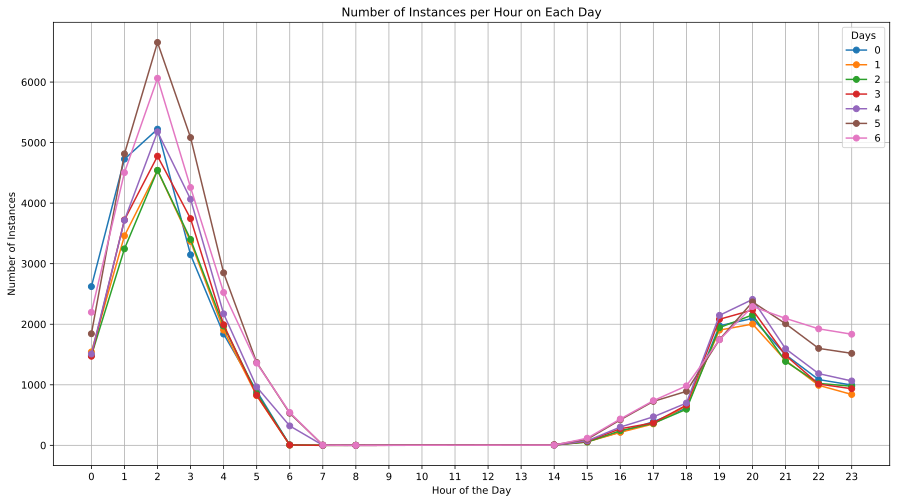

In [42]:
plt.figure(figsize=(15, 8))

for day in hourly_counts_by_day.index:

    hourly_counts_by_day.loc[day].plot(kind='line', marker='o', label=f'{day}')

plt.title('Number of Instances per Hour on Each Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Instances')
plt.xticks(range(24)) 
plt.grid(True)
plt.legend(title="Days")
plt.show()

In [43]:
hourly_counts_by_day = df.groupby(['day', 'hour']).size().unstack(fill_value=0)

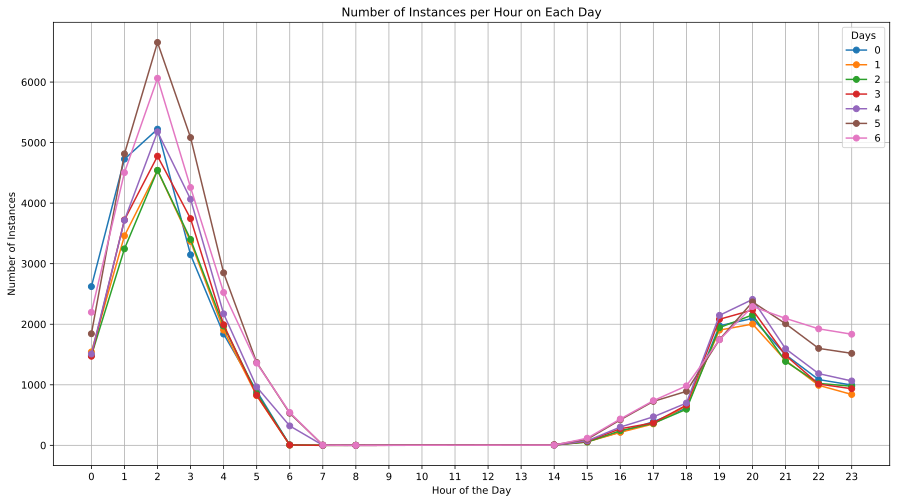

In [44]:
plt.figure(figsize=(15, 8))

for day in hourly_counts_by_day.index:

    hourly_counts_by_day.loc[day].plot(kind='line', marker='o', label=f'{day}')

plt.title('Number of Instances per Hour on Each Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Instances')
plt.xticks(range(24)) 
plt.grid(True)
plt.legend(title="Days")
plt.show()

In [45]:
hourly_counts_by_day = df.groupby(['day', 'hour']).size().unstack(fill_value=0)

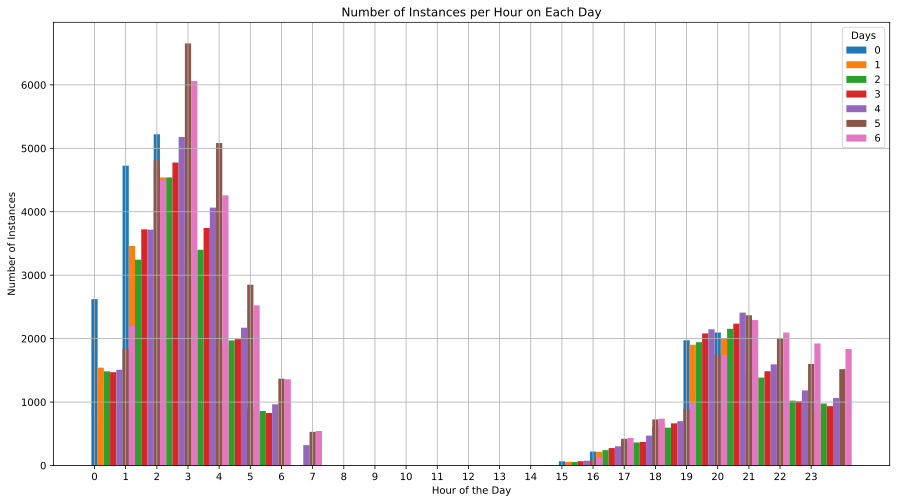

In [46]:
plt.figure(figsize=(15, 8))

for day in hourly_counts_by_day.index:

    plt.bar(hourly_counts_by_day.columns + (hourly_counts_by_day.index.get_loc(day) * 0.2), 
            hourly_counts_by_day.loc[day], width=0.2, label=str(day))

plt.title('Number of Instances per Hour on Each Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Instances')
plt.xticks(range(24)) 
plt.grid(True)
plt.legend(title="Days")
plt.show()

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 22 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   store_primary_category                        192668 non-null  object        
 5   order_protocol                                196433 non-null  float64       
 6   total_items                                   197428 non-null  int64         
 7   subtotal                                      197428 non-null  int64         
 8   num_distinct_items                            197428 n

#### heatmaps

In [48]:
heatmap_corr = df.select_dtypes(exclude=object).corr()

<Axes: >

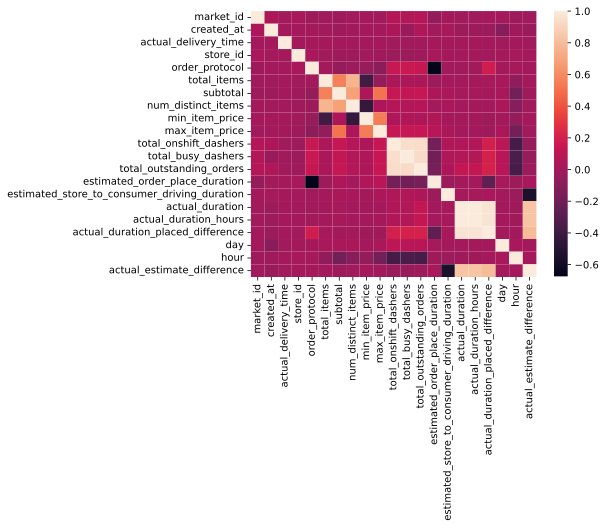

In [49]:
sns.heatmap(heatmap_corr)

In [50]:
corr_m = heatmap_corr[heatmap_corr.abs() < 1 > 0.6]

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [51]:
corr_pairs = corr_m.stack().reset_index()

NameError: name 'corr_m' is not defined

In [52]:
corr_pairs.columns = ['column1', 'column2', 'correlation']

NameError: name 'corr_pairs' is not defined

In [53]:
corr_pairs = corr_pairs.drop(corr_pairs.loc[corr_pairs['column1'] == corr_pairs['column2']].index)

NameError: name 'corr_pairs' is not defined

In [54]:
corr_pairs

NameError: name 'corr_pairs' is not defined

In [55]:
corr_pairs = corr_pairs.drop_duplicates()

NameError: name 'corr_pairs' is not defined

In [56]:
corr_vc = corr_pairs['correlation'].value_counts()

NameError: name 'corr_pairs' is not defined

In [57]:
vc_dups = corr_vc[corr_vc > 1].index

NameError: name 'corr_vc' is not defined

In [58]:
corr_minus_vc = corr_pairs[corr_pairs['correlation'].isin(vc_dups)]

NameError: name 'corr_pairs' is not defined

In [59]:
corr_minus_vc

NameError: name 'corr_minus_vc' is not defined

In [60]:
df['estimated_total'] = df['estimated_order_place_duration'] + df['estimated_store_to_consumer_driving_duration']

In [61]:
within_tolorence = (abs(df['actual_duration'] - df['estimated_total']) <= 600).sum()

In [62]:
precent_accuracy = (within_tolorence / len(df)) * 100

In [63]:
precent_accuracy

np.float64(20.04376278947262)

In [64]:
df['actual_estimate_difference'].sort_values(ascending=False)

2690      141535.650000
185550      5755.316667
27189       4774.366667
190860       581.450000
83055        348.533333
              ...      
195980              NaN
196097              NaN
197096              NaN
197209              NaN
197416              NaN
Name: actual_estimate_difference, Length: 197428, dtype: float64

In [65]:
df['created_at'].dt.hour.value_counts()

created_at
2     36976
1     28190
3     27068
20    15560
4     15250
19    13541
0     12669
21    11465
22     8821
23     8163
5      7096
18     5100
17     3413
16     2109
6      1416
15      538
14       40
7        11
8         2
Name: count, dtype: int64

#### onshift, busy, outstanding

In [66]:
grouped_onshift=df.groupby(['day', 'hour'])['total_onshift_dashers'].mean().reset_index()

In [174]:
grouped_df

,day,hour,total_onshift_dashers
0,0,0,35.335277
1,0,1,54.597839
2,0,2,61.237973
3,0,3,57.917838
4,0,4,42.135849
...,...,...,...
119,6,19,26.423913
120,6,20,34.626506
121,6,21,34.471331
122,6,22,31.369724


/Users/meganwilliams/miniconda3/envs/ddp/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/meganwilliams/miniconda3/envs/ddp/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/meganwilliams/miniconda3/envs/ddp/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/meganwilliams/miniconda3/envs/ddp/lib/python3.13/site-packages/seab

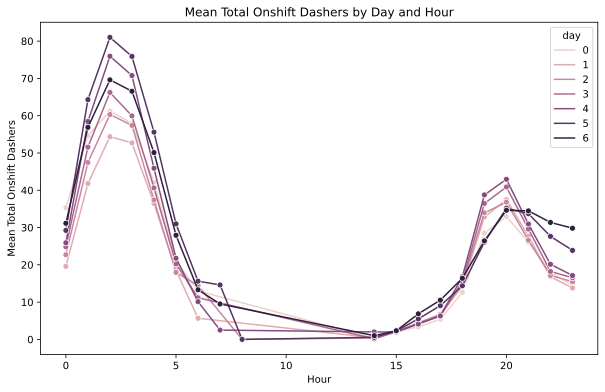

In [177]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=grouped_onshift, x='hour', y='total_onshift_dashers', hue='day', marker='o')

plt.title('Mean Total Onshift Dashers by Day and Hour')
plt.xlabel('Hour')
plt.ylabel('Mean Total Onshift Dashers')
plt.show()

#### filling market and category

In [196]:
df.groupby(['store_id','market_id'])['store_primary_category'].nunique().reset_index()

,store_id,market_id,store_primary_category
0,1,3.0,1
1,2,1.0,1
2,3,3.0,2
3,4,1.0,1
4,4,2.0,1
...,...,...,...
11959,6986,1.0,1
11960,6986,2.0,1
11961,6986,4.0,2
11962,6986,5.0,1


In [197]:
groupby_store_market = df.groupby('store_id')['market_id'].mode().reset_index()

In [201]:
ind = groupby_store_market.loc[groupby_store_market['market_id'] > 1].index

In [200]:
groupby_store_market_u = df.groupby('store_id')['market_id'].unique().reset_index()

In [202]:
groupby_store_market_u.loc[ind]

,store_id,market_id
3,4,"[1.0, 4.0, 6.0, 2.0, nan]"
8,9,"[4.0, 1.0]"
13,16,"[1.0, 3.0, nan, 4.0, 2.0]"
14,17,"[4.0, 6.0, 1.0]"
16,19,"[1.0, 3.0]"
...,...,...
6727,6971,"[1.0, 3.0, nan]"
6729,6973,"[1.0, 2.0]"
6734,6979,"[1.0, 3.0]"
6736,6981,"[5.0, 1.0, 4.0]"


In [194]:
groupby_store_category = df.groupby('store_id')['store_primary_category'].unique().reset_index()

In [195]:
groupby_store_category

,store_id,store_primary_category
0,1,[mexican]
1,2,[japanese]
2,3,"[salad, fast]"
3,4,"[fast, italian, asian, nan]"
4,5,[cafe]
...,...,...
6738,6983,[vietnamese]
6739,6984,[nan]
6740,6985,[latin-american]
6741,6986,"[fast, burger, pasta, indian, other]"


### starting over kind of 

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 23 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   store_primary_category                        192668 non-null  object        
 5   order_protocol                                196433 non-null  float64       
 6   total_items                                   197428 non-null  int64         
 7   subtotal                                      197428 non-null  int64         
 8   num_distinct_items                            197428 n

In [207]:
df = df.drop(columns='estimated_total')

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 22 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   store_primary_category                        192668 non-null  object        
 5   order_protocol                                196433 non-null  float64       
 6   total_items                                   197428 non-null  int64         
 7   subtotal                                      197428 non-null  int64         
 8   num_distinct_items                            197428 n

In [209]:
marketid_mode = df.groupby('store_id')['market_id'].agg(pd.Series.mode)

In [210]:
df['market_id'] = df['store_id'].map(marketid_mode)

In [212]:
category_mode = df.groupby('store_id')['store_primary_category'].agg(pd.Series.mode)

In [213]:
df['store_primary_category'] = df['store_id'].map(category_mode)

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 22 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     197428 non-null  object        
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   store_primary_category                        197428 non-null  object        
 5   order_protocol                                196433 non-null  float64       
 6   total_items                                   197428 non-null  int64         
 7   subtotal                                      197428 non-null  int64         
 8   num_distinct_items                            197428 n

In [7]:
result = df.dropna(subset=['store_id', 'market_id']).groupby('store_id')['market_id'].agg(pd.Series.mode).reset_index()

In [10]:
result

,store_id,market_id
0,1,3.0
1,2,1.0
2,3,3.0
3,4,1.0
4,5,6.0
...,...,...
6735,6983,1.0
6736,6984,6.0
6737,6985,1.0
6738,6986,4.0


In [11]:
df['market_id'] = df['store_id'].map(result['market_id'].iloc[0])

TypeError: 'numpy.float64' object is not callable

In [12]:
result = df.dropna(subset=['store_id', 'market_id']).groupby('store_id')['market_id'].agg(lambda x: x.mode().values[0] if len(x.mode()) > 0 else None)


In [22]:
result

store_id
1       3.0
2       1.0
3       3.0
4       1.0
5       6.0
       ... 
6983    1.0
6984    6.0
6985    1.0
6986    4.0
6987    3.0
Name: market_id, Length: 6740, dtype: float64

In [14]:
df['market_id'] = df['store_id'].map(result)

In [18]:
null_market = df.groupby('store_id')['market_id'].apply(lambda x: x.isna().all())

In [19]:
stores_with_nulls = null_market[null_market].index

In [21]:
print(stores_with_nulls)

Index([3258, 4122, 5774], dtype='int64', name='store_id')
